# 🎯 DCA Polymarket Backtesting v11

A modular backtesting framework for DCA strategies on Polymarket prediction markets.

**Features:**
- Multi-tier DCA entry strategy
- Stop-loss and take-profit management
- Optuna hyperparameter optimization
- Market analysis and visualization

**Expected data columns:** `datetime, asset_id, market_id, ob_best_bid, ob_best_ask, ob_mid_price, orderbook_bids, orderbook_asks`

---

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Loading](#2-data-loading)
3. [Core Functions](#3-core-functions)
4. [Backtest Engine](#4-backtest-engine)
5. [Visualization](#5-visualization)
6. [Optuna Optimizer](#6-optuna-optimizer)
7. [Market Analysis](#7-market-analysis)
8. [Known Winners](#8-known-winners)
9. [Run Backtest](#9-run-backtest)
10. [Run Optimization](#10-run-optimization)

---
## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import json
import warnings
from typing import Dict, List, Optional, Tuple
from collections import defaultdict

warnings.filterwarnings('ignore')
print("✅ Core imports ready")

✅ Core imports ready


In [2]:
# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Visualization imports ready")

✅ Visualization imports ready


In [3]:
!pip3 install optuna

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifacts.cf.saxo/artifactory/api/pypi/python/simple/


In [4]:
# Optional: Optuna for optimization
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
    print("✅ Optuna ready")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠️ Optuna not installed - optimization disabled")
    print("   Install with: pip install optuna")

✅ Optuna ready


---
## 2. Data Loading

In [5]:
# Mount Google Drive (Colab only)

"""
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("✅ Google Drive mounted")
except:
    IN_COLAB = False
    print("ℹ️ Not running in Colab - skipping Drive mount")"""

'\ntry:\n    from google.colab import drive\n    drive.mount(\'/content/drive\')\n    IN_COLAB = True\n    print("✅ Google Drive mounted")\nexcept:\n    IN_COLAB = False\n    print("ℹ️ Not running in Colab - skipping Drive mount")'

In [6]:
#!cp "/content/drive/MyDrive/Archive.zip" .
#!unzip Archive.zip -d extracted


In [7]:
# Configure your data paths here
DATA_PATHS = {
    '24jan': 'snapshot_24jan_reconstructed.parquet',
    '25jan': 'snapshots_25jan_reconstructed.parquet',
    '26jan': 'snapshot_26jan_reconstructed.parquet',
    '27jan': 'snapshots_27jan_reconstructed.parquet',
    '01feb': 'snapshots_1feb_reconstructed.parquet',
}

# If using Google Drive, update paths:
# DATA_PATHS = {
#     '24jan': '/content/drive/MyDrive/your_folder/snapshots_24jan_reconstructed.parquet',
#     ...
# }

In [8]:
def load_data(path: str) -> pd.DataFrame:
    """Load and validate parquet data."""
    df = pd.read_parquet(path)
    df['datetime'] = pd.to_datetime(df['datetime'])

    required_cols = ['datetime', 'asset_id', 'market_id', 'ob_best_bid', 'ob_best_ask']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    print(f"✅ Loaded {len(df):,} rows, {df['market_id'].nunique()} markets")
    print(f"   Time range: {df['datetime'].min()} to {df['datetime'].max()}")
    return df


def list_markets(df: pd.DataFrame):
    """Display available markets in the dataframe."""
    markets = df['market_id'].unique()
    print(f"\n📋 {len(markets)} Markets:")
    for i, m in enumerate(markets):
        n = len(df[df['market_id'] == m])
        print(f"  {i}: {m[:50]}... ({n:,} rows)")

In [9]:
# Example: Load one dataset
# df = load_data(DATA_PATHS['25jan'])
# list_markets(df)

---
## 3. Core Functions

Orderbook parsing and trade execution logic.

In [10]:
def parse_orderbook_levels(json_str: str) -> List[Dict]:
    """Parse orderbook levels from JSON string."""
    if not json_str or pd.isna(json_str):
        return []
    try:
        return json.loads(json_str)
    except:
        return []

In [11]:
def execute_buy(asks_json: str, amount_usd: float) -> Tuple[float, float, float]:
    """
    Execute buy order against asks.

    Args:
        asks_json: JSON string of ask levels
        amount_usd: Amount to spend in USD

    Returns:
        (shares_bought, total_cost, avg_price)
    """
    asks = parse_orderbook_levels(asks_json)
    if not asks or amount_usd <= 0:
        return 0, 0, 0

    shares, cost, remaining = 0, 0, amount_usd
    for level in asks:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining / p)
        shares += take
        cost += take * p
        remaining -= take * p

    return shares, cost, cost / shares if shares > 0 else 0

In [12]:
def execute_sell(bids_json: str, shares_to_sell: float) -> Tuple[float, float, float]:
    """
    Execute sell order against bids.

    Args:
        bids_json: JSON string of bid levels
        shares_to_sell: Number of shares to sell

    Returns:
        (shares_sold, total_proceeds, avg_price)
    """
    bids = parse_orderbook_levels(bids_json)
    if not bids or shares_to_sell <= 0:
        return 0, 0, 0

    sold, proceeds, remaining = 0, 0, shares_to_sell
    for level in bids:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining)
        sold += take
        proceeds += take * p
        remaining -= take

    return sold, proceeds, proceeds / sold if sold > 0 else 0


print("✅ Core functions ready")

✅ Core functions ready


---
## 4. Backtest Engine

The main DCA backtesting logic with configurable parameters.

In [13]:
# Default strategy parameters

DEFAULT_PARAMS = {
    'cooldown_periods': 6,
    'dca_tier_1': 0.9639,
    'dca_tier_2': 0.9744,
    'dca_tier_3': 0.9958,
    'entry_threshold': 0.9603,
    'exit_stop_loss': 0.7889,
    'stop_loss_pct': 0.1400,
    'take_profit_pct': 0.0350,
    'weight_entry': 0.4899,
    'weight_tier_1': 0.2783,
    'weight_tier_2': 0.1002,
    'weight_tier_3': 0.0572,
}


def normalize_params(params: Dict) -> Dict:
    """Normalize parameters with defaults and weight normalization."""
    p = DEFAULT_PARAMS.copy()
    p.update(params or {})

    # Normalize weights to sum to 1
    w_keys = ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']
    total = sum(p[k] for k in w_keys)
    for k in w_keys:
        p[k] /= total
    return p

In [ ]:
"""
DCA Backtest Engine v17

Features:
1. Late-game stop loss disable (after 90% market progress)
2. EARLY HEDGE - can trigger anytime on:
   a) Fast drop: X points in Y seconds (catches flash crashes)
   b) Slow drop: X points from entry price (catches slow bleeds)
3. Once hedged, SL disabled on main position
4. Grace period after entry - no SL for X seconds after buying
5. Hedge promotion rules (hedge outperforms → close main, promote hedge)
6. STABILITY-BASED EARLY ENTRY - enter earlier on stable trending markets
7. NEW: DOUBLE HEDGE - can hedge back to original asset if hedge position drops
   - Configurable max hedge count (default 2)
   - Cooldown between hedges to prevent flip-flopping
   - Tracks hedge history for analysis
"""

def calculate_stability_metrics(price_history: List[Tuple], window_seconds: int = 1800) -> Dict:
    """
    Calculate stability metrics from price history.
    
    Returns:
        dict with: volatility (std dev), min_price, max_price, avg_price, range, duration_above_threshold
    """
    if len(price_history) < 10:
        return {'volatility': float('inf'), 'avg_price': 0, 'range': float('inf'), 'valid': False}
    
    prices = [p for _, p in price_history]
    return {
        'volatility': np.std(prices),
        'avg_price': np.mean(prices),
        'min_price': min(prices),
        'max_price': max(prices),
        'range': max(prices) - min(prices),
        'valid': True
    }


def check_early_entry_eligible(
    price_history: List[Tuple],
    current_price: float,
    market_progress: float,
    ts: pd.Timestamp,
    # Early entry parameters
    early_entry_min_progress: float = 0.40,
    early_entry_max_progress: float = 0.90,
    early_entry_price_threshold: float = 0.70,
    early_entry_max_volatility: float = 0.03,
    early_entry_max_range: float = 0.08,
    early_entry_min_duration_minutes: float = 20,
    early_entry_no_drop_threshold: float = 0.06,
    early_entry_no_drop_window: int = 900,  # 15 min in seconds
) -> Tuple[bool, str]:
    """
    Check if early entry conditions are met for a stable trending market.
    
    The closer to late game, the more relaxed the stability requirements become.
    
    Returns:
        (eligible: bool, reason: str)
    """
    # Must be in the early entry window
    if market_progress < early_entry_min_progress or market_progress >= early_entry_max_progress:
        return False, "outside_early_window"
    
    # Price must be above threshold
    if current_price < early_entry_price_threshold:
        return False, f"price_{current_price:.2f}_below_{early_entry_price_threshold}"
    
    # Need enough price history
    if len(price_history) < 20:
        return False, "insufficient_history"
    
    # Calculate how close to late game we are (0 = just entered window, 1 = about to hit late game)
    progress_in_window = (market_progress - early_entry_min_progress) / (early_entry_max_progress - early_entry_min_progress)
    
    # Scale requirements: more relaxed as we approach late game
    # At 40% progress: need full stability | At 89% progress: much more relaxed
    relaxation_factor = progress_in_window  # 0 to 1
    
    # Adjusted thresholds (relax as we get closer to late game)
    adj_max_volatility = early_entry_max_volatility * (1 + relaxation_factor * 1.5)  # Up to 2.5x more volatile allowed
    adj_max_range = early_entry_max_range * (1 + relaxation_factor * 1.5)
    adj_min_duration = early_entry_min_duration_minutes * (1 - relaxation_factor * 0.6)  # Down to 40% of original
    
    # Calculate stability metrics
    metrics = calculate_stability_metrics(price_history)
    if not metrics['valid']:
        return False, "invalid_metrics"
    
    # Check volatility
    if metrics['volatility'] > adj_max_volatility:
        return False, f"volatility_{metrics['volatility']:.3f}_above_{adj_max_volatility:.3f}"
    
    # Check price range
    if metrics['range'] > adj_max_range:
        return False, f"range_{metrics['range']:.3f}_above_{adj_max_range:.3f}"
    
    # Check duration above threshold
    first_ts = price_history[0][0]
    duration_minutes = (ts - first_ts).total_seconds() / 60
    if duration_minutes < adj_min_duration:
        return False, f"duration_{duration_minutes:.1f}min_below_{adj_min_duration:.1f}min"
    
    # Check for recent drops (no flash crashes)
    recent_cutoff = ts - pd.Timedelta(seconds=early_entry_no_drop_window)
    recent_prices = [(t, p) for t, p in price_history if t >= recent_cutoff]
    if len(recent_prices) >= 2:
        recent_max = max(p for _, p in recent_prices)
        recent_drop = recent_max - current_price
        # Also scale the drop threshold
        adj_drop_threshold = early_entry_no_drop_threshold * (1 + relaxation_factor * 0.5)
        if recent_drop > adj_drop_threshold:
            return False, f"recent_drop_{recent_drop:.3f}_above_{adj_drop_threshold:.3f}"
    
    return True, f"stable_early_entry_progress_{market_progress:.1%}_vol_{metrics['volatility']:.3f}"


def run_backtest(
    df: pd.DataFrame,
    params: Dict = None,
    known_winners: Dict = None,
    initial_capital: float = 500,
    global_tp_pct: float = 0.20,
    selected_markets: List = None,
    resample: str = '1s',
    verbose: bool = True,
    # Late-game parameters
    late_game_threshold: float = 0.90,
    # Trading window restriction
    last_minutes_only: int = 10,          # Only trade in last X minutes (None = trade anytime)
    # === NEW: EARLY ENTRY PARAMETERS ===
    early_entry_enabled: bool = True,
    early_entry_min_progress: float = 0.40,      # Start checking at 40% market progress
    early_entry_max_progress: float = 0.90,      # Stop checking at 90% (late game takes over)
    early_entry_price_threshold: float = 0.70,   # Min price to consider early entry
    early_entry_max_volatility: float = 0.025,   # Max std dev for "stable"
    early_entry_max_range: float = 0.07,         # Max price range for "stable"
    early_entry_min_duration_minutes: float = 25, # Min time price must be stable
    early_entry_no_drop_threshold: float = 0.05, # Max recent drop allowed
    early_entry_no_drop_window: int = 900,       # Window for drop check (15 min)
    # Hedge parameters - FAST DROP
    hedge_enabled: bool = True,
    hedge_drop_points: float = 0.12,        # Fast drop: 12 points in window
    hedge_drop_window: int = 90,            # Fast drop: 90 seconds
    # Hedge parameters - SLOW DROP
    hedge_drop_from_entry: float = 0.10,    # Slow drop: 10 points from entry
    # Hedge general
    hedge_amount: float = 30.0,
    hedge_late_game_only: bool = True,      # Only hedge in late game
    # === NEW: DOUBLE HEDGE PARAMETERS ===
    double_hedge_enabled: bool = True,      # Allow hedging back to original asset
    max_hedge_count: int = 4,               # Max number of hedges per market (allows multiple flips)
    hedge_cooldown_seconds: int = 15,       # Min seconds between hedges (prevent flip-flop)
    double_hedge_drop_points: float = 0.08, # Drop threshold to trigger re-hedge (can be different)
    double_hedge_drop_from_entry: float = 0.08,  # Slow drop from hedge entry to trigger re-hedge
    # === NEW: PANIC FLIP / SAFETY SYSTEM ===
    panic_flip_enabled: bool = True,        # Enable/disable panic flip system
    panic_flip_threshold: float = 0.25,     # Price move threshold to trigger (e.g., 0.15 = 15 points)
    panic_flip_window: int = 30,            # Number of ticks to look back for the move
    panic_flip_min_price: float = 0.85,     # Only flip if winning side price >= this (confirming resolution)
    panic_flip_late_game_only: bool = True, # Only trigger in late game
    # Grace period
    entry_grace_period: int = 180,
    # Hedge PROMOTION parameters
    hedge_promotion_pnl_pct: float = 0.20,
    hedge_promotion_price: float = 0.50,    # Increased from 0.30 - don't promote sideways hedges
    hedge_promotion_delta: float = 0.15,
    # Instant exit
    instant_exit_price: float = 0.99,       # Exit ANY position instantly at this price
    # Noise filtering
    max_spread_for_sl: float = 0.10,        # Ignore tick for SL if spread > this
    sl_confirmation_ticks: int = 5,         # Need X consecutive ticks below SL to trigger
) -> Dict:
    """
    Run DCA backtest with stability-based early entry.

    NEW FEATURE - PANIC FLIP (SAFETY SYSTEM):
    Detects rapid price movement indicating market resolution is imminent.
    If we're on the wrong side, closes position and buys the winning side.
    
    Trigger conditions:
    1. Late game (configurable)
    2. One asset moves up >= panic_flip_threshold in panic_flip_window ticks
    3. That asset's price >= panic_flip_min_price (confirms it's winning)
    4. We have a position on the OTHER (losing) side
    
    Action: Close losing position, buy winning side with all available cash.

    NEW FEATURE - EARLY ENTRY:
    For stable trending markets, allows entry before the "last_minutes_only" window.
    
    Requirements for early entry (all must be met):
    1. Market progress between early_entry_min_progress and early_entry_max_progress
    2. Current price >= early_entry_price_threshold
    3. Low volatility (std dev) over observation period
    4. Small price range over observation period
    5. Price stable for minimum duration
    6. No significant recent drops
    
    The stability requirements are RELAXED as market progress increases:
    - At 40% progress: strictest stability requirements
    - At 89% progress: much more relaxed (almost ready for late game anyway)
    
    This catches markets like: stable at 0.75-0.80 for hours → enter at 60% instead of waiting
    until the last 10 minutes when price is already 0.99.
    """
    params = normalize_params(params)

    # Prepare data
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()

    # Market selection
    if selected_markets is not None:
        all_markets = df['market_id'].unique()
        sel = [all_markets[m] if isinstance(m, int) and m < len(all_markets) else m
               for m in selected_markets]
        df = df[df['market_id'].isin(sel)]

    if verbose:
        print(f"📊 {df['market_id'].nunique()} markets, {len(df):,} rows")

    # Resample if requested
    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
        df = df.sort_values('datetime')
        if verbose:
            print(f"⏱️  Resampled to {resample}: {len(df):,} rows")

    # Calculate market time bounds
    market_times = {}
    for mid in df['market_id'].unique():
        mdf = df[df['market_id'] == mid]
        market_times[mid] = {
            'start': mdf['datetime'].min(),
            'end': mdf['datetime'].max(),
            'duration': (mdf['datetime'].max() - mdf['datetime'].min()).total_seconds()
        }

    # Extract parameters
    ENTRY = params['entry_threshold']
    EXIT_SL = params['exit_stop_loss']
    SL_PCT = params['stop_loss_pct']
    TP_PCT = params['take_profit_pct']
    COOLDOWN = params['cooldown_periods']
    GLOBAL_TP = initial_capital * global_tp_pct

    DCA_TIERS = [
        ('entry', ENTRY, params['weight_entry']),
        ('tier_1', params['dca_tier_1'], params['weight_tier_1']),
        ('tier_2', params['dca_tier_2'], params['weight_tier_2']),
        ('tier_3', params['dca_tier_3'], params['weight_tier_3']),
    ]

    # Initialize market state
    markets = df['market_id'].unique()
    cap_per = initial_capital / len(markets)
    state = {
        m: {
            'alloc': cap_per,
            'cash': cap_per,
            'pos': {},
            'active': None,
            'tiers': set(),
            'pnl': 0,
            'cooldown': {},
            'sl_count': 0,
            'tp_count': 0,
            'price_history': {},
            'long_price_history': {},  # NEW: Longer history for stability checks
            'last_entry_time': {},
            # Hedge tracking
            'hedge_asset': None,
            'main_asset': None,
            'promoted': False,
            'promotion_reason': None,
            # 0.99 exit tracking
            'hit_99': False,
            # SL confirmation tracking
            'sl_below_count': {},
            # NEW: Early entry tracking
            'early_entry_triggered': False,
            'early_entry_reason': None,
            # NEW: Double hedge tracking
            'hedge_count': 0,                # Number of hedges executed
            'last_hedge_time': None,         # Timestamp of last hedge
            'hedge_history': [],             # List of hedge events: [(ts, from_asset, to_asset, reason)]
            'original_main': None,           # Track the very first main asset
            # NEW: Panic flip tracking
            'panic_flip_triggered': False,   # Whether panic flip was triggered
            'panic_flip_reason': None,       # Reason for panic flip
        }
        for m in markets
    }

    all_trades = []
    price_cache = {}
    global_tp_hit = False
    global_tp_ts = None
    early_entry_count = 0  # Track for summary
    panic_flip_count = 0   # Track for summary

    # Main simulation loop
    for _, row in df.iterrows():
        if global_tp_hit:
            break

        aid = row['asset_id']
        mid = row['market_id']
        ts = row['datetime']
        best_bid = row['ob_best_bid']
        best_ask = row['ob_best_ask']
        bids_json = row.get('orderbook_bids', '[]')
        asks_json = row.get('orderbook_asks', '[]')

        s = state[mid]
        current_price = (best_bid + best_ask) / 2
        price_cache[(mid, aid)] = current_price
        has_pos = aid in s['pos'] and s['pos'][aid]['shares'] > 0

        is_hedge = (aid == s['hedge_asset'])
        is_main = (aid == s['main_asset'])
        has_hedge = s['hedge_asset'] is not None

        # Calculate market progress
        mt = market_times[mid]
        if mt['duration'] > 0:
            elapsed = (ts - mt['start']).total_seconds()
            market_progress = min(elapsed / mt['duration'], 1.0)
        else:
            market_progress = 1.0

        in_late_game = market_progress >= late_game_threshold

        # Check if we're in the trading window (last X minutes)
        in_trading_window = True
        if last_minutes_only is not None:
            time_remaining = mt['duration'] - elapsed
            in_trading_window = time_remaining <= (last_minutes_only * 60)

        # Check grace period
        in_grace_period = False
        if aid in s['last_entry_time']:
            time_since_entry = (ts - s['last_entry_time'][aid]).total_seconds()
            in_grace_period = time_since_entry < entry_grace_period

        # Track price history (short - for hedge detection)
        if aid not in s['price_history']:
            s['price_history'][aid] = []
        s['price_history'][aid].append((ts, current_price))
        cutoff_time = ts - pd.Timedelta(seconds=300)
        s['price_history'][aid] = [(t, p) for t, p in s['price_history'][aid] if t >= cutoff_time]

        # NEW: Track LONG price history (for stability checks - 60 min)
        if aid not in s['long_price_history']:
            s['long_price_history'][aid] = []
        s['long_price_history'][aid].append((ts, current_price))
        long_cutoff = ts - pd.Timedelta(minutes=60)
        s['long_price_history'][aid] = [(t, p) for t, p in s['long_price_history'][aid] if t >= long_cutoff]

        # Global P&L check
        total_pnl = sum(st['pnl'] for st in state.values())
        total_pnl += sum(
            price_cache.get((m, a), 0) * p['shares'] - p['cost']
            for m, st in state.items()
            for a, p in st['pos'].items() if p['shares'] > 0
        )

        # Global take profit
        if total_pnl >= GLOBAL_TP:
            global_tp_hit = True
            global_tp_ts = ts
            for m, st in state.items():
                for a, p in st['pos'].items():
                    if p['shares'] > 0:
                        price = price_cache.get((m, a), 0.5)
                        proceeds = p['shares'] * price
                        pnl = proceeds - p['cost']
                        st['pnl'] += pnl
                        st['cash'] += proceeds
                        all_trades.append({
                            'ts': ts, 'market': m, 'asset': a,
                            'action': 'SELL', 'reason': 'GLOBAL_TP', 'pnl': pnl
                        })
            break

        # =================================================================
        # PANIC FLIP / SAFETY SYSTEM
        # Detects rapid price surge indicating imminent resolution
        # If we're on the wrong side, flip to the winning side
        # =================================================================
        if panic_flip_enabled and not s['panic_flip_triggered'] and not s['hit_99']:
            # Check if we should apply late-game restriction
            can_panic_flip = True
            if panic_flip_late_game_only and not in_late_game:
                can_panic_flip = False
            
            if can_panic_flip:
                # Check ALL assets in this market for rapid upward movement
                all_market_assets = df[df['market_id'] == mid]['asset_id'].unique()
                
                for check_aid in all_market_assets:
                    if s['panic_flip_triggered']:
                        break
                        
                    check_history = s['price_history'].get(check_aid, [])
                    if len(check_history) < 5:
                        continue
                    
                    # Get current price for this asset
                    check_price = price_cache.get((mid, check_aid), 0)
                    if check_price < panic_flip_min_price:
                        continue  # Not high enough to confirm winning
                    
                    # Check for rapid UPWARD move in this asset (tick-based window)
                    if len(check_history) >= panic_flip_window:
                        old_price = check_history[-panic_flip_window][1]
                    else:
                        old_price = check_history[0][1]  # Use oldest available if not enough ticks
                    
                    price_surge = check_price - old_price  # Positive = going UP
                    
                    if price_surge >= panic_flip_threshold:
                        # This asset is surging! Check if we have position on the OTHER side
                        other_assets = [a for a in all_market_assets if a != check_aid]
                        
                        for losing_aid in other_assets:
                            losing_pos = s['pos'].get(losing_aid, {'shares': 0, 'cost': 0})
                            
                            if losing_pos['shares'] > 0:
                                # We have a position on the LOSING side - PANIC FLIP!
                                panic_reason = f"PANIC_FLIP_surge_{price_surge:.2f}_in_{panic_flip_window}ticks_winner@{check_price:.2f}"
                                if verbose:
                                    print(f"🚨 PANIC FLIP [{mid[:20]}...]: {panic_reason}")
                                    print(f"   Closing losing position on {losing_aid[:15]}...")
                                
                                # Step 1: Close losing position
                                losing_bids = df[(df['market_id'] == mid) &
                                                (df['asset_id'] == losing_aid) &
                                                (df['datetime'] <= ts)]
                                if len(losing_bids) > 0:
                                    losing_bids_json = losing_bids.iloc[-1].get('orderbook_bids', '[]')
                                    sold, proceeds, _ = execute_sell(losing_bids_json, losing_pos['shares'])
                                    if sold > 0:
                                        pnl = proceeds - losing_pos['cost']
                                        s['pnl'] += pnl
                                        s['cash'] += proceeds
                                        s['pos'][losing_aid] = {'shares': 0, 'cost': 0}
                                        
                                        all_trades.append({
                                            'ts': ts, 'market': mid, 'asset': losing_aid,
                                            'action': 'SELL', 'reason': 'PANIC_CLOSE_LOSER',
                                            'pnl': pnl
                                        })
                                        
                                        if verbose:
                                            print(f"   Closed loser: ${pnl:+.2f}")
                                
                                # Step 2: Buy winning side with all available cash
                                winning_rows = df[(df['market_id'] == mid) &
                                                 (df['asset_id'] == check_aid) &
                                                 (df['datetime'] <= ts)]
                                if len(winning_rows) > 0 and s['cash'] > 1:
                                    winning_asks = winning_rows.iloc[-1].get('orderbook_asks', '[]')
                                    buy_amount = s['cash'] * 0.95  # Use 95% of cash
                                    
                                    shares, cost, avg_p = execute_buy(winning_asks, buy_amount)
                                    if shares > 0:
                                        if check_aid not in s['pos']:
                                            s['pos'][check_aid] = {'shares': 0, 'cost': 0}
                                        s['pos'][check_aid]['shares'] += shares
                                        s['pos'][check_aid]['cost'] += cost
                                        s['cash'] -= cost
                                        
                                        all_trades.append({
                                            'ts': ts, 'market': mid, 'asset': check_aid,
                                            'action': 'BUY', 'reason': 'PANIC_BUY_WINNER',
                                            'cost': cost, 'shares': shares
                                        })
                                        
                                        if verbose:
                                            print(f"   Bought winner: ${cost:.2f} @ {avg_p:.2f}")
                                
                                # Mark panic flip as done for this market
                                s['panic_flip_triggered'] = True
                                s['panic_flip_reason'] = panic_reason
                                s['main_asset'] = check_aid
                                s['hedge_asset'] = None
                                s['active'] = check_aid
                                panic_flip_count += 1
                                break  # Done with this market

        # =================================================================
        # HEDGE TRIGGER - DUAL CHECK (Fast drop OR Slow drop from entry)
        # NOW SUPPORTS DOUBLE HEDGE - can hedge back if current position drops
        # RUNS BEFORE PROMOTION CHECK so double hedge can trigger first
        # =================================================================
        spread = best_ask - best_bid
        tick_is_noisy = spread > max_spread_for_sl

        main_aid = s['main_asset']
        has_main_pos = main_aid and main_aid in s['pos'] and s['pos'][main_aid]['shares'] > 0
        is_main_row = (aid == main_aid)

        # Check hedge cooldown
        hedge_on_cooldown = False
        if s['last_hedge_time'] is not None:
            time_since_hedge = (ts - s['last_hedge_time']).total_seconds()
            hedge_on_cooldown = time_since_hedge < hedge_cooldown_seconds

        # ORIGINAL HEDGE: Main position drops, hedge to opposite
        # NOTE: Promoted positions CAN hedge again - they're just regular mains now
        can_hedge = (hedge_enabled and has_main_pos and not s['hedge_asset'] and
                     is_main_row and not s['hit_99'] and 
                     not tick_is_noisy and not hedge_on_cooldown and
                     s['hedge_count'] < max_hedge_count)

        # DOUBLE HEDGE: Hedge position drops, hedge back to main (or another asset)
        is_hedge_row = (aid == s['hedge_asset'])
        hedge_pos_for_check = s['pos'].get(s['hedge_asset'], {'shares': 0}) if s['hedge_asset'] else {'shares': 0}
        has_hedge_pos = hedge_pos_for_check['shares'] > 0
        
        # Double hedge also allowed even if previously promoted
        can_double_hedge = (double_hedge_enabled and hedge_enabled and has_hedge_pos and
                           is_hedge_row and not s['hit_99'] and
                           not tick_is_noisy and not hedge_on_cooldown and
                           s['hedge_count'] < max_hedge_count)

        if hedge_late_game_only and not in_late_game:
            can_hedge = False
            can_double_hedge = False

        hedge_triggered_this_tick = False

        # DEBUG: Print why double hedge can't trigger (periodically)
        if s['hedge_asset'] and is_hedge_row and verbose and has_hedge_pos:
            hedge_pos_debug = s['pos'].get(s['hedge_asset'], {'shares': 0, 'cost': 0})
            if hedge_pos_debug['shares'] > 0:
                h_avg = hedge_pos_debug['cost'] / hedge_pos_debug['shares']
                h_drop = h_avg - current_price
                if int(ts.timestamp()) % 30 == 0:  # Every 30 seconds
                    print(f"   [DBG DBLHEDGE] {mid[:15]}... hedge_price={current_price:.2f} entry={h_avg:.2f} drop={h_drop:.2f} need={double_hedge_drop_from_entry}")
                    print(f"      can_double_hedge={can_double_hedge} cooldown={hedge_on_cooldown} count={s['hedge_count']}/{max_hedge_count}")

        # -----------------------------------------------------------------
        # DOUBLE HEDGE LOGIC (hedge position drops → hedge back)
        # CHECK THIS FIRST before original hedge
        # -----------------------------------------------------------------
        if can_double_hedge:
            trigger_double_hedge = False
            double_hedge_reason = ""

            hedge_aid = s['hedge_asset']
            hedge_pos_data = s['pos'].get(hedge_aid, {'shares': 0, 'cost': 0})
            
            if hedge_pos_data['shares'] > 0:
                hedge_avg_entry = hedge_pos_data['cost'] / hedge_pos_data['shares']

                # CHECK 1: FAST DROP on hedge position
                history = s['price_history'].get(hedge_aid, [])
                if len(history) >= 2:
                    window_start = ts - pd.Timedelta(seconds=hedge_drop_window)
                    old_prices = [(t, p) for t, p in history if t <= window_start]

                    if old_prices:
                        old_price = old_prices[-1][1]
                        fast_drop = old_price - current_price

                        if fast_drop >= double_hedge_drop_points:
                            trigger_double_hedge = True
                            double_hedge_reason = f"DOUBLE_FAST_DROP_{fast_drop:.2f}_in_{hedge_drop_window}s"

                # CHECK 2: SLOW DROP from hedge entry
                if not trigger_double_hedge:
                    drop_from_hedge_entry = hedge_avg_entry - current_price

                    if drop_from_hedge_entry >= double_hedge_drop_from_entry:
                        trigger_double_hedge = True
                        double_hedge_reason = f"DOUBLE_SLOW_DROP_{drop_from_hedge_entry:.2f}_from_hedge_entry_{hedge_avg_entry:.2f}"

            # EXECUTE DOUBLE HEDGE (buy back into original main or opposite)
            if trigger_double_hedge:
                all_assets = df[df['market_id'] == mid]['asset_id'].unique()
                # Hedge back to the opposite of current hedge (which is the original main)
                opposite_assets = [a for a in all_assets if a != hedge_aid]

                if opposite_assets and s['cash'] >= hedge_amount:
                    # Prefer going back to original main if it exists
                    if s['original_main'] in opposite_assets:
                        target_aid = s['original_main']
                    else:
                        target_aid = opposite_assets[0]
                    
                    target_rows = df[(df['market_id'] == mid) &
                                    (df['asset_id'] == target_aid) &
                                    (df['datetime'] <= ts)]

                    if len(target_rows) > 0:
                        target_row = target_rows.iloc[-1]
                        target_asks = target_row.get('orderbook_asks', '[]')

                        shares, cost, avg_p = execute_buy(target_asks, hedge_amount)
                        if shares > 0:
                            if target_aid not in s['pos']:
                                s['pos'][target_aid] = {'shares': 0, 'cost': 0}
                            s['pos'][target_aid]['shares'] += shares
                            s['pos'][target_aid]['cost'] += cost
                            s['cash'] -= cost

                            # Swap: old hedge becomes main, new purchase becomes hedge
                            old_hedge = s['hedge_asset']
                            s['main_asset'] = old_hedge  # The dropping hedge is now "main"
                            s['hedge_asset'] = target_aid  # New purchase is the hedge
                            s['hedge_count'] += 1
                            s['last_hedge_time'] = ts
                            s['hedge_history'].append((ts, old_hedge, target_aid, double_hedge_reason))
                            hedge_triggered_this_tick = True

                            all_trades.append({
                                'ts': ts, 'market': mid, 'asset': target_aid,
                                'action': 'BUY', 'reason': f'DOUBLE_HEDGE_{s["hedge_count"]}',
                                'cost': cost, 'shares': shares
                            })

                            if verbose:
                                print(f"🔄 DOUBLE HEDGE #{s['hedge_count']} [{mid[:20]}...]: {double_hedge_reason}")
                                print(f"   Bought ${cost:.2f} @ {avg_p:.2f} | Hedge was @ {current_price:.2f}")

        # -----------------------------------------------------------------
        # ORIGINAL HEDGE LOGIC (main → opposite)
        # -----------------------------------------------------------------
        elif can_hedge:
            trigger_hedge = False
            hedge_reason = ""

            main_pos = s['pos'].get(aid, {'shares': 0, 'cost': 0})
            if main_pos['shares'] > 0:
                avg_entry = main_pos['cost'] / main_pos['shares']

                # CHECK 1: FAST DROP
                history = s['price_history'][aid]
                if len(history) >= 2:
                    window_start = ts - pd.Timedelta(seconds=hedge_drop_window)
                    old_prices = [(t, p) for t, p in history if t <= window_start]

                    if old_prices:
                        old_price = old_prices[-1][1]
                        fast_drop = old_price - current_price

                        if fast_drop >= hedge_drop_points:
                            trigger_hedge = True
                            hedge_reason = f"FAST_DROP_{fast_drop:.2f}_in_{hedge_drop_window}s"

                # CHECK 2: SLOW DROP
                if not trigger_hedge:
                    drop_from_entry = avg_entry - current_price

                    if drop_from_entry >= hedge_drop_from_entry:
                        trigger_hedge = True
                        hedge_reason = f"SLOW_DROP_{drop_from_entry:.2f}_from_entry_{avg_entry:.2f}"

            # EXECUTE HEDGE
            if trigger_hedge:
                all_assets = df[df['market_id'] == mid]['asset_id'].unique()
                opposite_assets = [a for a in all_assets if a != aid]

                if opposite_assets and s['cash'] >= hedge_amount:
                    opp_aid = opposite_assets[0]
                    opp_rows = df[(df['market_id'] == mid) &
                                 (df['asset_id'] == opp_aid) &
                                 (df['datetime'] <= ts)]

                    if len(opp_rows) > 0:
                        opp_row = opp_rows.iloc[-1]
                        opp_asks = opp_row.get('orderbook_asks', '[]')

                        shares, cost, avg_p = execute_buy(opp_asks, hedge_amount)
                        if shares > 0:
                            if opp_aid not in s['pos']:
                                s['pos'][opp_aid] = {'shares': 0, 'cost': 0}
                            s['pos'][opp_aid]['shares'] += shares
                            s['pos'][opp_aid]['cost'] += cost
                            s['cash'] -= cost

                            # Track original main on first hedge
                            if s['original_main'] is None:
                                s['original_main'] = aid
                            
                            s['hedge_asset'] = opp_aid
                            s['main_asset'] = aid
                            s['hedge_count'] += 1
                            s['last_hedge_time'] = ts
                            s['hedge_history'].append((ts, aid, opp_aid, hedge_reason))
                            hedge_triggered_this_tick = True

                            all_trades.append({
                                'ts': ts, 'market': mid, 'asset': opp_aid,
                                'action': 'BUY', 'reason': f'HEDGE_{s["hedge_count"]}',
                                'cost': cost, 'shares': shares
                            })

                            if verbose:
                                print(f"🛡️ HEDGE #{s['hedge_count']} [{mid[:20]}...]: {hedge_reason}")
                                print(f"   Bought ${cost:.2f} @ {avg_p:.2f} | Main @ {current_price:.2f}")

        # =================================================================
        # HEDGE PROMOTION CHECK (runs AFTER hedge checks)
        # =================================================================
        if s['hedge_asset'] and s['main_asset'] and not s['promoted'] and not hedge_triggered_this_tick:
            hedge_aid = s['hedge_asset']
            main_aid = s['main_asset']

            hedge_pos = s['pos'].get(hedge_aid, {'shares': 0, 'cost': 0})
            main_pos = s['pos'].get(main_aid, {'shares': 0, 'cost': 0})

            if hedge_pos['shares'] > 0 and main_pos['shares'] > 0:
                hedge_price = price_cache.get((mid, hedge_aid), 0)
                main_price = price_cache.get((mid, main_aid), 0)

                hedge_value = hedge_pos['shares'] * hedge_price
                hedge_pnl = hedge_value - hedge_pos['cost']
                hedge_return = hedge_pnl / hedge_pos['cost'] if hedge_pos['cost'] > 0 else 0

                main_value = main_pos['shares'] * main_price
                main_pnl = main_value - main_pos['cost']
                main_return = main_pnl / main_pos['cost'] if main_pos['cost'] > 0 else 0

                promote = False
                reason = None

                if hedge_pnl >= hedge_promotion_pnl_pct * main_pos['cost']:
                    promote = True
                    reason = f'HEDGE_PNL_{hedge_pnl:.2f}>={hedge_promotion_pnl_pct*100:.0f}%_MAIN'
                elif hedge_price >= hedge_promotion_price:
                    promote = True
                    reason = f'HEDGE_PRICE_{hedge_price:.2f}>={hedge_promotion_price}'
                elif hedge_return - main_return >= hedge_promotion_delta:
                    promote = True
                    reason = f'HEDGE_DELTA_{(hedge_return-main_return)*100:.1f}%>={hedge_promotion_delta*100:.0f}%'

                if promote:
                    if verbose:
                        print(f"🔄 PROMOTION [{mid[:20]}...]: {reason}")
                        print(f"   Main: ${main_pnl:+.2f} ({main_return*100:+.1f}%) @ {main_price:.2f}")
                        print(f"   Hedge: ${hedge_pnl:+.2f} ({hedge_return*100:+.1f}%) @ {hedge_price:.2f}")

                    # Close main position
                    main_bids = df[(df['market_id'] == mid) &
                                   (df['asset_id'] == main_aid) &
                                   (df['datetime'] <= ts)]
                    if len(main_bids) > 0:
                        main_bids_json = main_bids.iloc[-1].get('orderbook_bids', '[]')
                        sold, proceeds, _ = execute_sell(main_bids_json, main_pos['shares'])
                        if sold > 0:
                            pnl = proceeds - main_pos['cost']
                            s['pnl'] += pnl
                            s['cash'] += proceeds
                            s['pos'][main_aid] = {'shares': 0, 'cost': 0}

                            all_trades.append({
                                'ts': ts, 'market': mid, 'asset': main_aid,
                                'action': 'SELL', 'reason': 'PROMOTION_CLOSE_MAIN',
                                'pnl': pnl
                            })

                    s['promoted'] = True
                    s['promotion_reason'] = reason
                    s['main_asset'] = hedge_aid
                    s['hedge_asset'] = None
                    s['active'] = hedge_aid

        # =================================================================
        # EXIT LOGIC
        # =================================================================
        if has_pos:
            p = s['pos'][aid]
            if p['shares'] <= 0:
                continue
            avg = p['cost'] / p['shares']
            exit_reason = None

            spread = best_ask - best_bid
            tick_is_noisy = spread > max_spread_for_sl

            has_hedge_now = s['hedge_asset'] is not None

            # INSTANT EXIT AT 0.99
            if best_bid >= instant_exit_price:
                exit_reason = 'EXIT_99'
                s['hit_99'] = True

            elif is_hedge:
                pass

            elif s['promoted']:
                pass

            elif has_hedge_now and is_main:
                if best_bid >= avg * (1 + TP_PCT):
                    exit_reason = 'TAKE_PROFIT'

            else:
                sl_active = True

                if in_late_game:
                    sl_active = False
                if in_grace_period:
                    sl_active = False

                if sl_active and not tick_is_noisy:
                    below_sl = False
                    sl_type = None

                    if best_bid < EXIT_SL:
                        below_sl = True
                        sl_type = 'STOP_LOSS_ABS'
                    elif best_bid < avg * (1 - SL_PCT):
                        below_sl = True
                        sl_type = 'STOP_LOSS_PCT'

                    if below_sl:
                        if aid not in s['sl_below_count']:
                            s['sl_below_count'][aid] = 0
                        s['sl_below_count'][aid] += 1

                        if s['sl_below_count'][aid] >= sl_confirmation_ticks:
                            exit_reason = sl_type
                    else:
                        s['sl_below_count'][aid] = 0

                if best_bid >= avg * (1 + TP_PCT):
                    exit_reason = 'TAKE_PROFIT'

            if exit_reason:
                sold, proceeds, _ = execute_sell(bids_json, p['shares'])
                if sold > 0:
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    s['pos'][aid] = {'shares': 0, 'cost': 0}

                    if is_main or (not s['hedge_asset'] and not s['promoted']):
                        s['active'] = None
                        s['tiers'] = set()

                    s['cooldown'][aid] = ts + pd.Timedelta(seconds=30 * COOLDOWN)
                    if 'STOP' in exit_reason:
                        s['sl_count'] += 1
                    else:
                        s['tp_count'] += 1
                    all_trades.append({
                        'ts': ts, 'market': mid, 'asset': aid,
                        'action': 'SELL', 'reason': exit_reason, 'pnl': pnl
                    })
                continue

        # Cooldown check
        if aid in s['cooldown']:
            if ts < s['cooldown'][aid]:
                continue
            del s['cooldown'][aid]

        # =================================================================
        # ENTRY/DCA LOGIC - WITH EARLY ENTRY CHECK
        # =================================================================
        if s['hit_99']:
            continue

        # =================================================================
        # NEW: CHECK FOR EARLY ENTRY (stable markets)
        # =================================================================
        allow_early_entry = False
        if early_entry_enabled and not in_trading_window and s['active'] is None:
            # Check if this asset qualifies for early entry
            long_history = s['long_price_history'].get(aid, [])
            
            eligible, reason = check_early_entry_eligible(
                price_history=long_history,
                current_price=current_price,
                market_progress=market_progress,
                ts=ts,
                early_entry_min_progress=early_entry_min_progress,
                early_entry_max_progress=early_entry_max_progress,
                early_entry_price_threshold=early_entry_price_threshold,
                early_entry_max_volatility=early_entry_max_volatility,
                early_entry_max_range=early_entry_max_range,
                early_entry_min_duration_minutes=early_entry_min_duration_minutes,
                early_entry_no_drop_threshold=early_entry_no_drop_threshold,
                early_entry_no_drop_window=early_entry_no_drop_window,
            )
            
            if eligible:
                allow_early_entry = True
                if verbose and not s['early_entry_triggered']:
                    print(f"🌅 EARLY ENTRY [{mid[:20]}...]: {reason}")
                    print(f"   Progress: {market_progress:.1%} | Price: {current_price:.2f}")

        # Block entries if not in trading window AND not early entry eligible
        if not in_trading_window and not allow_early_entry:
            continue

        if best_ask >= ENTRY and not s['promoted']:
            if s['active'] is None:
                s['active'] = aid
                s['main_asset'] = aid
                # Track if this was an early entry
                if allow_early_entry and not s['early_entry_triggered']:
                    s['early_entry_triggered'] = True
                    s['early_entry_reason'] = "stable_market"
                    early_entry_count += 1

            if s['active'] == aid:
                for tier, thresh, weight in DCA_TIERS:
                    if tier in s['tiers'] or best_ask < thresh:
                        continue

                    amt = min(s['alloc'] * weight, s['cash'])
                    if amt <= 1:
                        continue

                    shares, cost, avg_p = execute_buy(asks_json, amt)
                    if shares > 0:
                        if aid not in s['pos']:
                            s['pos'][aid] = {'shares': 0, 'cost': 0}
                        s['pos'][aid]['shares'] += shares
                        s['pos'][aid]['cost'] += cost
                        s['cash'] -= cost
                        s['tiers'].add(tier)

                        s['last_entry_time'][aid] = ts

                        # Mark reason for trade
                        entry_reason = tier
                        if allow_early_entry and tier == 'entry':
                            entry_reason = 'EARLY_' + tier

                        all_trades.append({
                            'ts': ts, 'market': mid, 'asset': aid,
                            'action': 'BUY', 'reason': entry_reason,
                            'cost': cost, 'shares': shares
                        })
                        break

    # =================================================================
    # MARKET CLOSE
    # =================================================================
    if not global_tp_hit:
        for mid, s in state.items():
            for aid, p in s['pos'].items():
                if p['shares'] > 0:
                    if known_winners and mid in known_winners:
                        close_price = 1.0 if aid == known_winners[mid] else 0.0
                    else:
                        close_price = price_cache.get((mid, aid), 0.5)

                    proceeds = p['shares'] * close_price
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds

                    reason = 'MARKET_CLOSE'
                    if aid == s.get('hedge_asset'):
                        reason = 'MARKET_CLOSE_HEDGE'
                    elif s['promoted'] and aid == s.get('main_asset'):
                        reason = 'MARKET_CLOSE_PROMOTED'

                    all_trades.append({
                        'ts': None, 'market': mid, 'asset': aid,
                        'action': 'SELL', 'reason': reason, 'pnl': pnl
                    })

    # =================================================================
    # RESULTS
    # =================================================================
    final_value = sum(s['cash'] for s in state.values())
    total_pnl = sum(s['pnl'] for s in state.values())
    trades_df = pd.DataFrame(all_trades) if all_trades else pd.DataFrame()

    if len(trades_df) > 0 and 'pnl' in trades_df.columns:
        wins = len(trades_df[trades_df['pnl'] > 0])
        losses = len(trades_df[trades_df['pnl'] < 0])
    else:
        wins, losses = 0, 0

    if len(trades_df) > 0 and 'reason' in trades_df.columns:
        hedge_count = len(trades_df[trades_df['reason'].str.startswith('HEDGE_', na=False)])
        double_hedge_count = len(trades_df[trades_df['reason'].str.startswith('DOUBLE_HEDGE_', na=False)])
        promotion_count = len(trades_df[trades_df['reason'] == 'PROMOTION_CLOSE_MAIN'])
        early_entries = len(trades_df[trades_df['reason'].str.startswith('EARLY_', na=False)])
        panic_flip_count = len(trades_df[trades_df['reason'] == 'PANIC_BUY_WINNER'])
    else:
        hedge_count, double_hedge_count, promotion_count, early_entries, panic_flip_count = 0, 0, 0, 0, 0

    results = {
        'total_return': (final_value - initial_capital) / initial_capital,
        'total_pnl': total_pnl,
        'final_value': final_value,
        'wins': wins,
        'losses': losses,
        'win_rate': wins / (wins + losses) if (wins + losses) > 0 else 0,
        'sl_count': sum(s['sl_count'] for s in state.values()),
        'tp_count': sum(s['tp_count'] for s in state.values()),
        'hedge_count': hedge_count,
        'double_hedge_count': double_hedge_count,
        'promotion_count': promotion_count,
        'early_entry_count': early_entry_count,
        'panic_flip_count': panic_flip_count,  # NEW
        'global_tp_hit': global_tp_hit,
        'global_tp_ts': global_tp_ts,
        'trades': trades_df,
        'market_state': state,
        'params': params,
    }

    if verbose:
        print("\n" + "=" * 50)
        print("💰 RESULTS")
        print("=" * 50)
        print(f"Capital: ${initial_capital:.2f} → ${final_value:.2f} ({results['total_return']*100:+.1f}%)")
        print(f"P&L: ${total_pnl:+.2f} | Win Rate: {results['win_rate']*100:.0f}%")
        print(f"Wins: {wins} | Losses: {losses} | SL: {results['sl_count']} | TP: {results['tp_count']}")
        if hedge_count > 0 or double_hedge_count > 0:
            print(f"🛡️ Hedges: {hedge_count} | Double Hedges: {double_hedge_count} | Promotions: {promotion_count}")
        if early_entry_count > 0:
            print(f"🌅 Early Entries: {early_entry_count} (stable markets)")
        if panic_flip_count > 0:
            print(f"🚨 Panic Flips: {panic_flip_count} (rapid resolution detected)")
        if global_tp_hit:
            print(f"🎯 Global TP hit at {global_tp_ts}")
        print("\n📋 Per Market:")
        for i, (m, s) in enumerate(state.items()):
            status = ""
            if s['early_entry_triggered']:
                status = " [EARLY]"
            if s['hedge_count'] > 1:
                status += f" [HEDGE x{s['hedge_count']}]"
            elif s['hedge_asset']:
                status += " [HEDGED]"
            if s['promoted']:
                status += " [PROMOTED]"
            if s.get('panic_flip_triggered'):
                status += " [PANIC FLIP]"
            print(f"   {i}: ${s['pnl']:+.2f}{status}")

    return results


print("✅ Backtest engine v17 ready")
print("   Features:")
print("   - Stability-based early entry")
print("   - DOUBLE HEDGE: Can hedge back when hedge position drops")
print("   - Configurable max_hedge_count and hedge_cooldown_seconds")

✅ Backtest engine v17 ready
   Features:
   - Stability-based early entry
   - DOUBLE HEDGE: Can hedge back when hedge position drops
   - Configurable max_hedge_count and hedge_cooldown_seconds


In [15]:


selected_markets_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
    '0xbf399bc9894b502586ad0ed7383fffcadb07c21c507fb2a84a991741763a8efc': '35923522612276750394651557626496020946647566899591212994355411047671496757110',
    '0xf6a808c701b3432667fc8f21b3fe05259264cb45276aa7fcd2a7d486bfaa3601': '88289804616935923809321119252865056808373694473082600665834909738008415308474',
    '0xa9c0c820fd79b4339ed4711288ce15236196a6015234350f42b37341e9094398': '91609514063242777856043730063938310894548353925882406409927495687846407164056',
    '0xf42921f761a9553b33c3bcfebc42f48218b9147cf33d137f8daf28da996d5642': '72061868768744363794309804812683635190849437054114408108529113134643926789227',
}

selected_markets_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
}


selected_markets_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}

selected_markets_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}


known_winners_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
    '0xbf399bc9894b502586ad0ed7383fffcadb07c21c507fb2a84a991741763a8efc': '35923522612276750394651557626496020946647566899591212994355411047671496757110',
    '0xf6a808c701b3432667fc8f21b3fe05259264cb45276aa7fcd2a7d486bfaa3601': '88289804616935923809321119252865056808373694473082600665834909738008415308474',
    '0xa9c0c820fd79b4339ed4711288ce15236196a6015234350f42b37341e9094398': '91609514063242777856043730063938310894548353925882406409927495687846407164056',
    '0xf42921f761a9553b33c3bcfebc42f48218b9147cf33d137f8daf28da996d5642': '72061868768744363794309804812683635190849437054114408108529113134643926789227',
}


known_winners_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
}

known_winners_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}

known_winners_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}


✅ Loaded 2,403,298 rows, 6 markets
   Time range: 2026-01-24 21:04:08.656000 to 2026-01-25 10:19:16.502000
📊 6 markets, 2,322,722 rows
⏱️  Resampled to 1s: 182,580 rows
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.1%_vol_0.004
   Progress: 40.1% | Price: 0.70
🌅 EAR

---
## 5. Visualization

Functions for plotting price data and backtest results.

In [16]:
def plot_market(df: pd.DataFrame, market_index: int = 0, figsize=(16, 6)):
    """
    Plot price development for a single market.

    Args:
        df: DataFrame with price data
        market_index: Index of market to plot
        figsize: Figure dimensions
    """
    markets = df['market_id'].unique()
    if market_index >= len(markets):
        print(f"❌ Market index {market_index} out of range (max {len(markets)-1})")
        return None

    market_id = markets[market_index]
    mdf = df[df['market_id'] == market_id].copy()
    mdf['datetime'] = pd.to_datetime(mdf['datetime'])
    mdf = mdf.sort_values('datetime')

    fig, ax = plt.subplots(figsize=figsize)
    colors = ['#2196F3', '#FF9800', '#4CAF50', '#E91E63']
    assets = mdf['asset_id'].unique()

    for i, asset_id in enumerate(assets):
        adf = mdf[mdf['asset_id'] == asset_id].sort_values('datetime')
        color = colors[i % len(colors)]
        mid = (adf['ob_best_bid'] + adf['ob_best_ask']) / 2
        ax.plot(adf['datetime'], mid, color=color, alpha=0.8, linewidth=1.5,
                label=f'Asset {i+1}')
        ax.fill_between(adf['datetime'], adf['ob_best_bid'], adf['ob_best_ask'],
                       color=color, alpha=0.1)

    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'Market {market_index + 1}\n{market_id[:60]}...', fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    return fig

In [17]:
def plot_backtest(df: pd.DataFrame, results: Dict, market_index: int = 0, figsize=(16, 8)):
    """
    Plot backtest results with entry/exit markers.

    Args:
        df: DataFrame used for backtest
        results: Output from run_backtest()
        market_index: Index of market to plot
        figsize: Figure dimensions
    """
    params = results.get('params', {})
    trades_df = results.get('trades', pd.DataFrame())
    market_state = results.get('market_state', {})

    markets = list(market_state.keys())
    if market_index >= len(markets):
        print(f"❌ Market index {market_index} out of range (max {len(markets)-1})")
        return None

    market_id = markets[market_index]
    market_pnl = market_state[market_id]['pnl']

    mdf = df[df['market_id'] == market_id].copy()
    mdf['datetime'] = pd.to_datetime(mdf['datetime'])
    mdf = mdf.sort_values('datetime')

    # Get trades for this market (handle both DataFrame and empty cases)
    if isinstance(trades_df, pd.DataFrame) and len(trades_df) > 0 and 'market' in trades_df.columns:
        mtrades = trades_df[trades_df['market'] == market_id].copy()
    else:
        mtrades = pd.DataFrame()

    fig, ax = plt.subplots(figsize=figsize)
    colors = ['#2196F3', '#FF9800', '#4CAF50', '#E91E63']
    assets = mdf['asset_id'].unique()

    # Plot price lines
    for i, asset_id in enumerate(assets):
        adf = mdf[mdf['asset_id'] == asset_id].sort_values('datetime')
        color = colors[i % len(colors)]
        mid = (adf['ob_best_bid'] + adf['ob_best_ask']) / 2
        ax.plot(adf['datetime'], mid, color=color, alpha=0.7, linewidth=1.5,
                label=f'Asset {i+1}')
        ax.fill_between(adf['datetime'], adf['ob_best_bid'], adf['ob_best_ask'],
                       color=color, alpha=0.1)

    # Plot strategy thresholds
    if params:
        entry_thresh = params.get('entry_threshold', 0.68)
        exit_sl = params.get('exit_stop_loss', 0.50)
        ax.axhline(y=entry_thresh, color='green', linestyle='--', alpha=0.5,
                   linewidth=1.5, label=f'Entry ({entry_thresh:.2f})')
        ax.axhline(y=exit_sl, color='red', linestyle='--', alpha=0.5,
                   linewidth=1.5, label=f'Stop Loss ({exit_sl:.2f})')
        for tier in ['dca_tier_1', 'dca_tier_2', 'dca_tier_3']:
            if tier in params:
                ax.axhline(y=params[tier], color='gray', linestyle=':', alpha=0.3)

    # Plot trade markers
    if len(mtrades) > 0 and 'ts' in mtrades.columns:
        # Buy markers
        buys = mtrades[mtrades['action'] == 'BUY']
        for _, trade in buys.iterrows():
            if pd.isna(trade['ts']):
                continue
            ts = pd.to_datetime(trade['ts'])
            trade_asset = trade.get('asset', None)
            # Filter to the specific asset that was traded
            asset_df = mdf[mdf['asset_id'] == trade_asset] if trade_asset else mdf
            if len(asset_df) == 0:
                asset_df = mdf
            closest = asset_df.iloc[(asset_df['datetime'] - ts).abs().argsort()[:1]]
            if len(closest) > 0:
                price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                ax.scatter(ts, price, marker='^', s=150, c='green',
                          edgecolors='darkgreen', linewidths=1.5, zorder=5)
                tier = trade.get('reason', '')
                ax.annotate(tier, (ts, price), textcoords="offset points",
                           xytext=(0, 10), ha='center', fontsize=8, color='green')

        # Sell markers
        sells = mtrades[mtrades['action'] == 'SELL']
        for _, trade in sells.iterrows():
            ts = trade.get('ts')
            if pd.isna(ts):
                continue
            ts = pd.to_datetime(ts)
            trade_asset = trade.get('asset', None)
            # Filter to the specific asset that was traded
            asset_df = mdf[mdf['asset_id'] == trade_asset] if trade_asset else mdf
            if len(asset_df) == 0:
                asset_df = mdf
            closest = asset_df.iloc[(asset_df['datetime'] - ts).abs().argsort()[:1]]
            if len(closest) > 0:
                price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                pnl = trade.get('pnl', 0)
                color = 'blue' if pnl > 0 else 'red'
                edge = 'darkblue' if pnl > 0 else 'darkred'
                ax.scatter(ts, price, marker='v', s=150, c=color,
                          edgecolors=edge, linewidths=1.5, zorder=5)
                reason = trade.get('reason', '')
                ax.annotate(f"{reason}\n${pnl:+.2f}", (ts, price),
                           textcoords="offset points", xytext=(0, -20),
                           ha='center', fontsize=7, color=color)

    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'Market {market_index + 1} | P&L: ${market_pnl:+.2f}\n{market_id[:50]}...', fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    return fig

In [18]:
def plot_all_markets(df: pd.DataFrame, results: Dict = None, figsize=(16, 6)):
    """
    Plot all markets. If results provided, includes trade markers.

    Args:
        df: DataFrame with price data
        results: Optional backtest results
        figsize: Figure dimensions
    """
    if results:
        markets = list(results['market_state'].keys())
        print(f"📊 Plotting {len(markets)} markets with trades...\n")
        for i in range(len(markets)):
            plot_backtest(df, results, market_index=i, figsize=figsize)
    else:
        markets = df['market_id'].unique()
        print(f"📊 Plotting {len(markets)} markets...\n")
        for i in range(len(markets)):
            plot_market(df, market_index=i, figsize=figsize)


print("✅ Visualization functions ready")

✅ Visualization functions ready


In [19]:
#plot_all_markets(df, results)

---
## 6. Optuna Optimizer

Hyperparameter optimization across multiple datasets.

In [20]:
def run_optuna(
    datasets: List,
    n_trials: int = 100,
    initial_capital: float = 500,
    global_tp_pct: float = 0.07,
    resample: str = '1s',
    param_ranges: Dict = None,
    conservative: bool = False
):
    """
    Optimize strategy parameters using Optuna.

    Args:
        datasets: List of (df, known_winners, selected_markets, name) tuples
        n_trials: Number of optimization trials
        initial_capital: Starting capital per dataset
        global_tp_pct: Global take profit percentage
        resample: Resample interval
        param_ranges: Custom parameter ranges
        conservative: Use conservative ranges (entry >= 0.95)

    Returns:
        (study, best_params, per_dataset_results)
    """
    if not OPTUNA_AVAILABLE:
        raise ImportError("Optuna not installed. Run: pip install optuna")

    # Default parameter ranges
    if conservative:
        default_ranges = {
            'entry_threshold': (0.95, 0.99),
            'exit_stop_loss': (0.75, 0.92),
            'stop_loss_pct': (0.02, 0.10),
            'take_profit_pct': (0.01, 0.08),
            'cooldown_periods': (3, 15),
            'dca_tier_1': (0.96, 0.99),
            'dca_tier_2': (0.97, 0.995),
            'dca_tier_3': (0.98, 0.999),
            'weight_entry': (0.30, 0.60),
            'weight_tier_1': (0.15, 0.35),
            'weight_tier_2': (0.10, 0.25),
            'weight_tier_3': (0.05, 0.20),
        }
    else:
        default_ranges = {
            'entry_threshold': (0.60, 0.97),
            'exit_stop_loss': (0.40, 0.70),
            'stop_loss_pct': (0.05, 0.25),
            'take_profit_pct': (0.08, 0.35),
            'cooldown_periods': (3, 25),
            'dca_tier_1': (0.62, 0.99),
            'dca_tier_2': (0.64, 0.995),
            'dca_tier_3': (0.68, 0.999),
            'weight_entry': (0.08, 0.30),
            'weight_tier_1': (0.10, 0.35),
            'weight_tier_2': (0.15, 0.40),
            'weight_tier_3': (0.20, 0.45),
        }

    if param_ranges:
        default_ranges.update(param_ranges)
    ranges = default_ranges

    # Prepare datasets
    print(f"📊 Preparing {len(datasets)} dataset(s)...")
    prepared = []

    for i, item in enumerate(datasets):
        if len(item) == 4:
            data, known_winners, selected_markets, name = item
        elif len(item) == 3:
            data, known_winners, selected_markets = item
            name = f'dataset_{i+1}'
        else:
            raise ValueError(f"Dataset {i} format error")

        # Load if path
        if isinstance(data, str):
            print(f"   Loading {data}...")
            data = pd.read_parquet(data)

        data = data.copy()
        data['datetime'] = pd.to_datetime(data['datetime'])

        if selected_markets is not None:
            if isinstance(selected_markets, dict):
                selected_markets = list(selected_markets.keys())
            data = data[data['market_id'].isin(selected_markets)]

        data = data[data['ob_best_bid'].notna() & data['ob_best_ask'].notna()].copy()

        if resample:
            data['bucket'] = data['datetime'].dt.floor(resample)
            data = data.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
            data = data.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
            data = data.sort_values('datetime')

        n_markets = data['market_id'].nunique()
        print(f"   ✓ {name}: {len(data):,} rows, {n_markets} markets")
        prepared.append((data, known_winners, name))

    print()

    def objective(trial):
        params = {
            'entry_threshold': trial.suggest_float('entry_threshold', *ranges['entry_threshold']),
            'exit_stop_loss': trial.suggest_float('exit_stop_loss', *ranges['exit_stop_loss']),
            'stop_loss_pct': trial.suggest_float('stop_loss_pct', *ranges['stop_loss_pct']),
            'take_profit_pct': trial.suggest_float('take_profit_pct', *ranges['take_profit_pct']),
            'cooldown_periods': trial.suggest_int('cooldown_periods', *ranges['cooldown_periods']),
            'dca_tier_1': trial.suggest_float('dca_tier_1', *ranges['dca_tier_1']),
            'dca_tier_2': trial.suggest_float('dca_tier_2', *ranges['dca_tier_2']),
            'dca_tier_3': trial.suggest_float('dca_tier_3', *ranges['dca_tier_3']),
            'weight_entry': trial.suggest_float('weight_entry', *ranges['weight_entry']),
            'weight_tier_1': trial.suggest_float('weight_tier_1', *ranges['weight_tier_1']),
            'weight_tier_2': trial.suggest_float('weight_tier_2', *ranges['weight_tier_2']),
            'weight_tier_3': trial.suggest_float('weight_tier_3', *ranges['weight_tier_3']),
        }

        # Ensure tier ordering
        if not (params['entry_threshold'] < params['dca_tier_1'] < params['dca_tier_2'] < params['dca_tier_3']):
            return -1.0

        total_return = 0
        for data, known_winners, name in prepared:
            try:
                res = run_backtest(
                    data, params=params, known_winners=known_winners,
                    initial_capital=initial_capital, global_tp_pct=global_tp_pct,
                    resample=None, verbose=False
                )
                total_return += res['total_return']
            except:
                return -1.0

        return total_return / len(prepared)

    print(f"🚀 Running {n_trials} trials...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # Results
    print(f"\n{'='*60}")
    print(f"🏆 OPTIMIZATION RESULTS")
    print(f"{'='*60}")
    print(f"Best avg return: {study.best_value*100:+.2f}%")

    print(f"\n📋 Best parameters:")
    best = study.best_params
    for k, v in sorted(best.items()):
        print(f"   {k}: {v:.4f}" if isinstance(v, float) else f"   {k}: {v}")

    # Test on each dataset
    print(f"\n📊 Per-dataset results:")
    per_dataset_results = {}

    for data, known_winners, name in prepared:
        res = run_backtest(
            data, params=best, known_winners=known_winners,
            initial_capital=initial_capital, global_tp_pct=global_tp_pct,
            resample=None, verbose=False
        )
        per_dataset_results[name] = res
        print(f"   {name}: ${res['total_pnl']:+.2f} ({res['total_return']*100:+.1f}%) "
              f"| W:{res['wins']} L:{res['losses']}")

    total_pnl = sum(r['total_pnl'] for r in per_dataset_results.values())
    avg_return = sum(r['total_return'] for r in per_dataset_results.values()) / len(per_dataset_results)
    print(f"\n   TOTAL: ${total_pnl:+.2f} | Avg return: {avg_return*100:+.1f}%")

    return study, best, per_dataset_results


if OPTUNA_AVAILABLE:
    print("✅ Optuna optimizer ready")

✅ Optuna optimizer ready


---
## 7. Market Analysis

Analyze market characteristics and threshold statistics.

In [21]:
def analyze_markets(
    df: pd.DataFrame,
    known_winners: Dict,
    thresholds: List[float] = None,
    resample: str = '5s',
    verbose: bool = True
) -> Dict:
    """
    Analyze market data for threshold performance.

    Args:
        df: DataFrame with orderbook data
        known_winners: Dict of market_id -> winning asset_id
        thresholds: Price thresholds to analyze
        resample: Resample interval
        verbose: Print output

    Returns:
        Dict with analysis results
    """
    if thresholds is None:
        thresholds = [0.85, 0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()

    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})

    markets = df['market_id'].unique()

    if verbose:
        print(f"📊 Analyzing {len(markets)} markets, {len(df):,} rows")
        print(f"📅 Time range: {df['datetime'].min()} to {df['datetime'].max()}\n")

    # Threshold stats
    threshold_stats = {t: {
        'assets_touched': 0, 'winners_touched': 0, 'losers_touched': 0
    } for t in thresholds}

    for mid in markets:
        mdf = df[df['market_id'] == mid]
        winner_aid = known_winners.get(mid)

        for aid in mdf['asset_id'].unique():
            adf = mdf[mdf['asset_id'] == aid]
            max_ask = adf['ob_best_ask'].max()
            is_winner = (aid == winner_aid)

            for t in thresholds:
                if max_ask >= t:
                    threshold_stats[t]['assets_touched'] += 1
                    if is_winner:
                        threshold_stats[t]['winners_touched'] += 1
                    else:
                        threshold_stats[t]['losers_touched'] += 1

    if verbose:
        print("=" * 70)
        print("📈 THRESHOLD ANALYSIS")
        print("=" * 70)
        print(f"{'Threshold':<12} {'Assets':<10} {'Winners':<10} {'Losers':<10} {'Win Rate':<12}")
        print("-" * 70)
        for t in sorted(thresholds):
            s = threshold_stats[t]
            total = s['assets_touched']
            win_rate = s['winners_touched'] / total * 100 if total > 0 else 0
            print(f"{t:<12.2f} {total:<10} {s['winners_touched']:<10} "
                  f"{s['losers_touched']:<10} {win_rate:<11.1f}%")

    return {'threshold_stats': threshold_stats, 'n_markets': len(markets)}


print("✅ Analysis functions ready")

✅ Analysis functions ready


---
## 8. Known Winners

Market outcome data for backtesting.

In [22]:
# 24 January
known_winners_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}

selected_markets_24jan = list(known_winners_24jan.keys())

In [23]:
# 25 January
known_winners_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}

selected_markets_25jan = list(known_winners_25jan.keys())

In [24]:
# 26 January
known_winners_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
    #'0x09aa5f4210ff3e17e65072e73bf084a1d72246ec712b8d33c4efbc958192a435': '112460056466301987895624067988030855175451380171501724318327858610989988015996',
}

selected_markets_26jan = list(known_winners_26jan.keys())

In [25]:
# 27 January
known_winners_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470': '105917824473601761478847321769933632598106021887333748710627510244193706793258',
    '0xfbbca64429c68fe60f8b7f5713cb7c2b6e3f0b72ad72ead6e30c7bd7f03d2328': '114403476857604701724608088874049221045243705059599768206726165533185920136385',
    '0x96efea44484d3752fa72dc3ca5987c2e16a006112dbbe0174730b8ad5932c98f': '518272430027893766986552798258835853433678957912568820764900306532617260527',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x6cefa261bfbee131da94a3ca013886a58606ae27055175ee62910251cd9aa532': '81640735300133043464899322835663435037559272815252333754895208703479291308029',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
}

selected_markets_27jan = list(known_winners_27jan.keys())

print("✅ Known winners loaded")

✅ Known winners loaded


In [26]:
known_winners_1feb = {
    '0x045decb722882afaf0d7073fcee0e258157648fbb39834d79b3a5c4c87f55f5c': '47914109276976795228171596329183196073418801725090548023772993109187195119102', #bucacnners
    '0x69dd6cdc5026979f6b91432997a72a646bdbd9974c8bbc97c6fee84f9b593860': '35507679041658691421113946209792145726790636549803609308451765849153829282684', #pistons
    '0xe27314abed3ee02d34879131f9cb58ac6ae8cf99d554f8d3787f7e5891136bf0': '49451720559536207793651194331382402132359704214117870228018524488985344367475', #
    '0xc8c05c3b44e67dfa6e2e9621751df029a9e29f2b09610571a0a9f3cad5a00f31': '26112071446814965402999048891641754983996549455934167336095987299380637999450', #cavaliers
    '0x57edace77a734a5df5f27b7b9120351e6cb65c295298e1e14acf78fb3ed05ad6': '4621351331926841526016002617363536723536461848217261221656656989817918684696', #clippers
    '0x4bf5c88fd2d848ef9263100e6b71a4ad65f032ee51da6a1a7727cfa9eed96934': '88583007069540440685836742484888009905331163639550673068046284859288460643884', # knicks
    '0xdb264f66040a967e13a4de5ebdee5fcfb0f826454b4b409a807b9d7222c1cb68': '101971266276864678863554426688496696165714598981788215573271274390814686396324', #thunder
    '0xb8556936a9327f016822d938a0ca62bb9bf5a325a98a2a373d0de2f3fe13fd2f': '101962832390240355913931476340349239068949031036967665157922908391872847118001', #spurs
    '0xbaa2377f797eb0661f4457ca26bb18fe45fefffc7f686c3a76c2bc05688ca22e': '74489684361478237889335886769358759614273687619166546551579716934861841022764',#wizards
    '0xff7d45a68af8a7ec25ee7d4cf1fba33f8578087e4b8e36893452b493d13f95a1': '59325667443396724746830154919871636532815974483012166602106258099779573654373', #raptors
}

selected_markets_1feb = list(known_winners_1feb.keys())

---
## 9. Run Backtest

Example backtest execution.

In [27]:
# Define your parameters
my_params = {
    'entry_threshold': 0.7412,
    'exit_stop_loss': 0.5440,
    'stop_loss_pct': 0.1354,
    'take_profit_pct': 0.3406,
    'cooldown_periods': 21,
    'dca_tier_1': 0.7916,
    'dca_tier_2': 0.8382,
    'dca_tier_3': 0.8501,
    'weight_entry': 0.1064,
    'weight_tier_1': 0.3337,
    'weight_tier_2': 0.2735,
    'weight_tier_3': 0.2382,
}

print("📋 Parameters configured")

📋 Parameters configured


In [28]:
"""results = run_backtest(df, params=my_params, known_winners=known_winners_27jan,
                       selected_markets=['0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470'], verbose=True)"""

"results = run_backtest(df, params=my_params, known_winners=known_winners_27jan,\n                       selected_markets=['0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470'], verbose=True)"

In [31]:
# Load data and run backtest
# Uncomment to run:

df = load_data(DATA_PATHS['24jan'])
results = run_backtest(
     df,
     params=my_params,
     known_winners=known_winners_24jan,
     selected_markets=selected_markets_24jan,
     initial_capital=500,
     resample='1s'
)

✅ Loaded 2,403,298 rows, 6 markets
   Time range: 2026-01-24 21:04:08.656000 to 2026-01-25 10:19:16.502000
📊 5 markets, 2,043,950 rows
⏱️  Resampled to 1s: 121,826 rows
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.0%_vol_0.004
   Progress: 40.0% | Price: 0.70
🌅 EARLY ENTRY [0x188710cca5d961454b...]: stable_early_entry_progress_40.1%_vol_0.004
   Progress: 40.1% | Price: 0.70
🌅 EAR

📊 Plotting 5 markets with trades...



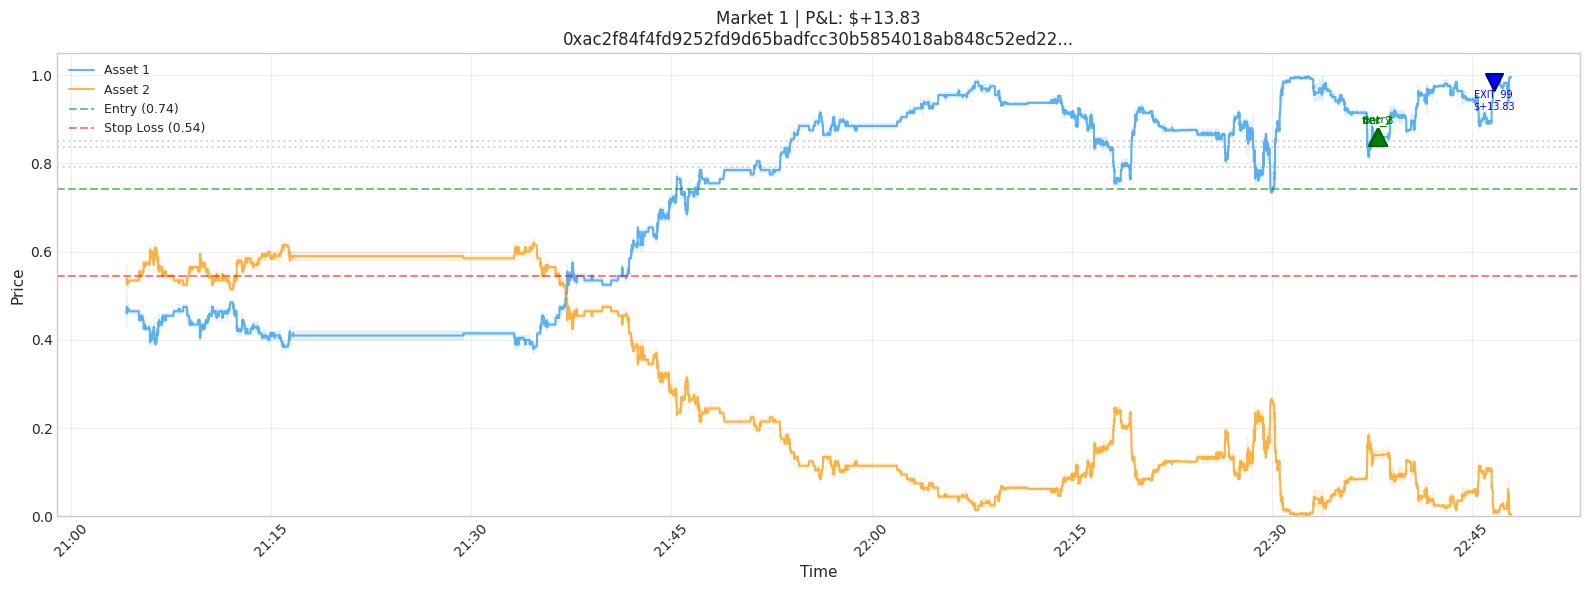

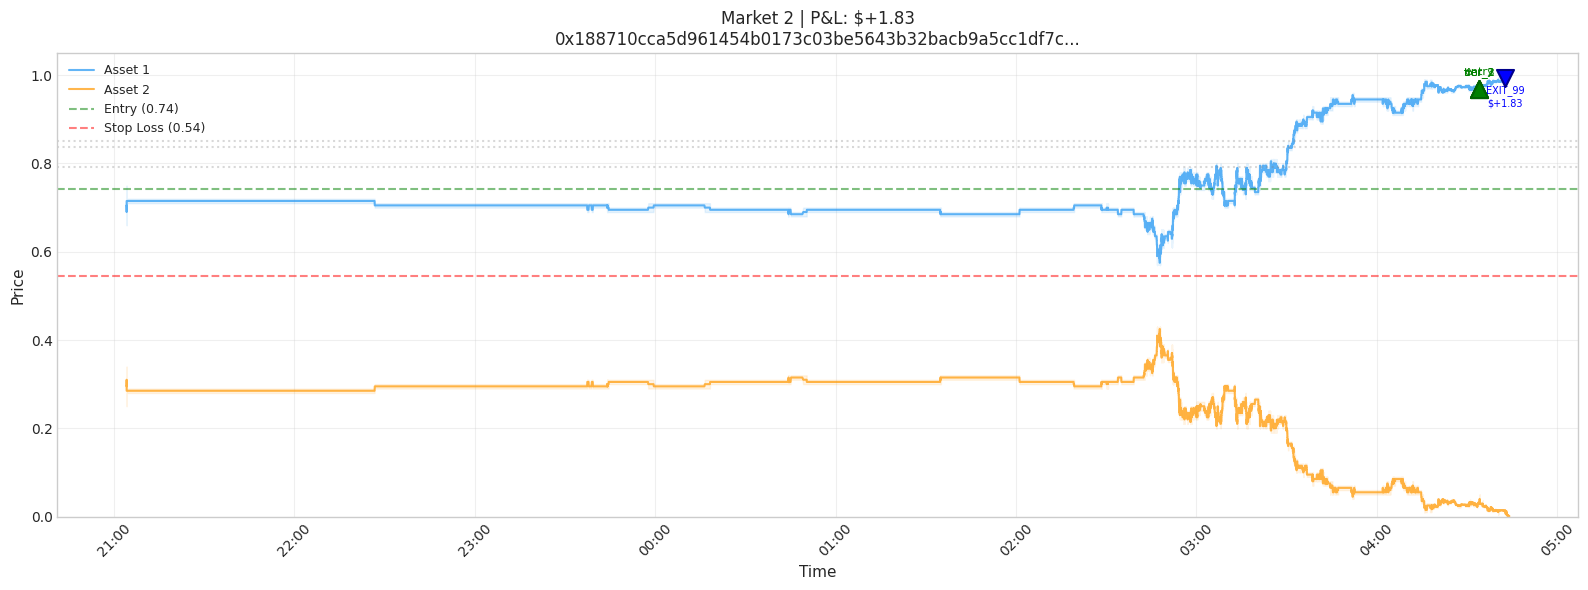

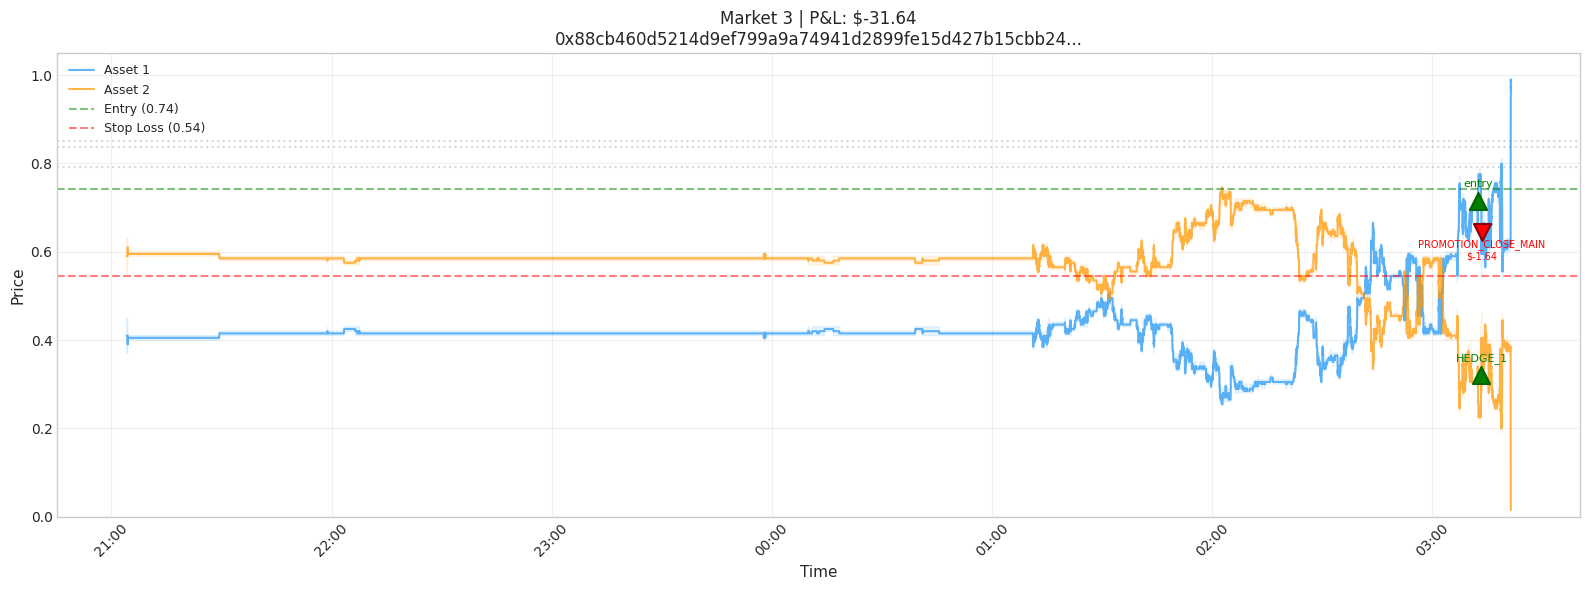

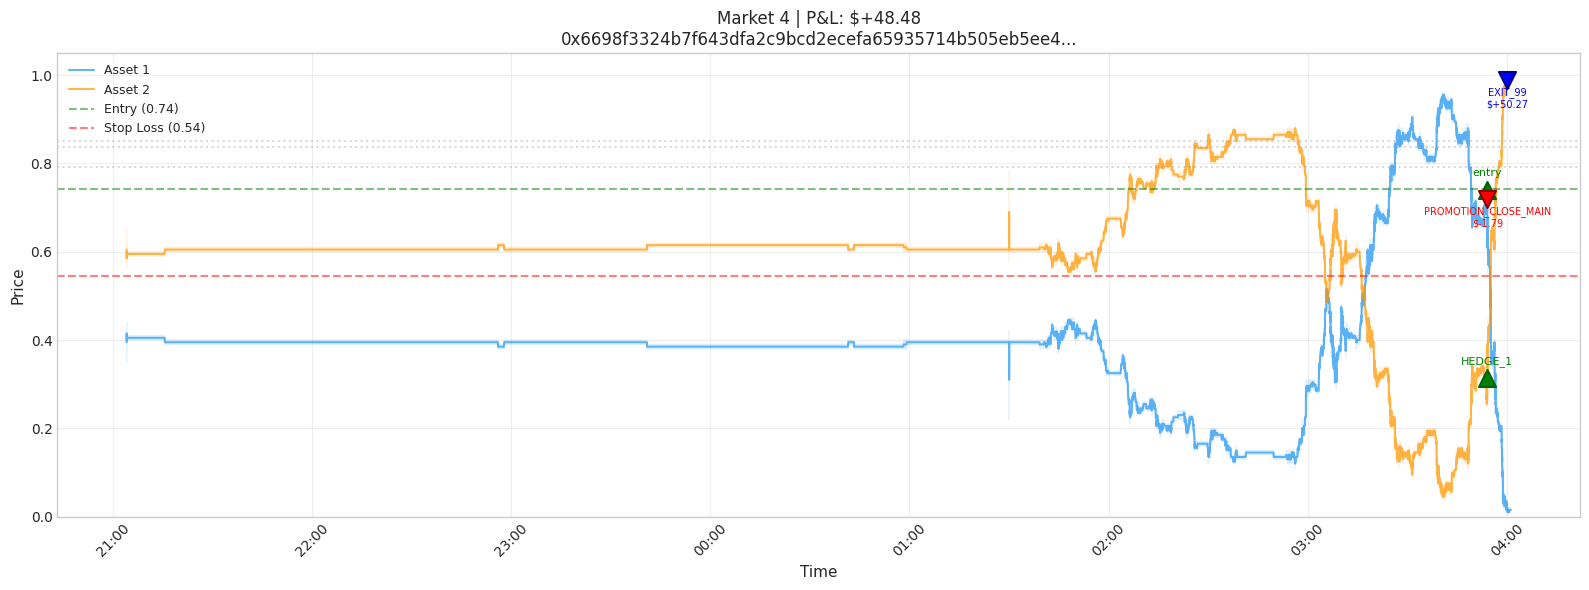

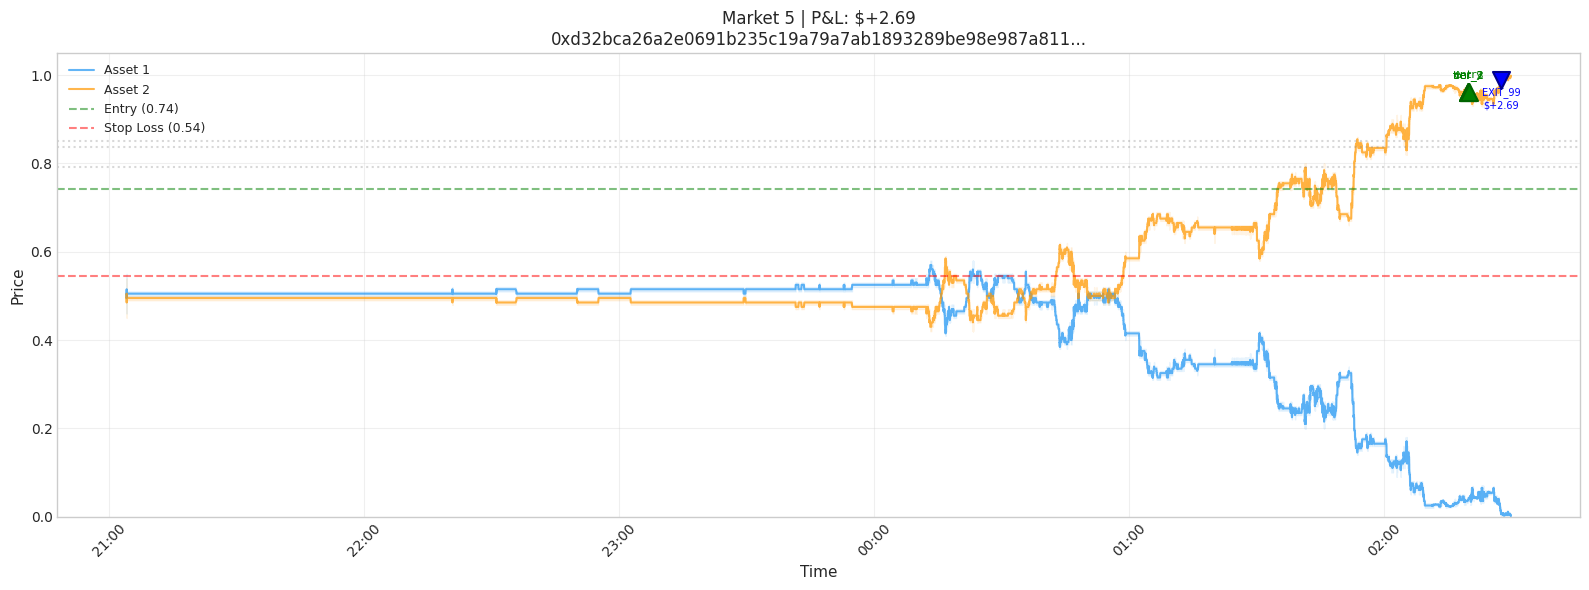

In [32]:
# Visualize results
# Uncomment after running backtest:

#plot_backtest(df, results, market_index=0)
plot_all_markets(df, results)

---
## 10. Run Optimization

Multi-dataset parameter optimization.

In [44]:
# Load all datasets for optimization
# Uncomment to run:

df_24 = load_data(DATA_PATHS['24jan'])
df_25 = load_data(DATA_PATHS['25jan'])
df_26 = load_data(DATA_PATHS['26jan'])
df_27 = load_data(DATA_PATHS['27jan'])

✅ Loaded 2,403,298 rows, 6 markets
   Time range: 2026-01-24 21:04:08.656000 to 2026-01-25 10:19:16.502000
✅ Loaded 1,817,932 rows, 6 markets
   Time range: 2026-01-25 22:52:30.696000 to 2026-01-26 08:30:45.252000
✅ Loaded 2,060,124 rows, 6 markets
   Time range: 2026-01-26 20:18:29.891000 to 2026-01-27 06:50:48.137000
✅ Loaded 3,609,174 rows, 15 markets
   Time range: 2026-01-27 23:56:45.623000 to 2026-01-28 08:46:50.488000


In [45]:
# Define datasets for optimization
datasets = [
    (df_24, known_winners_24jan, selected_markets_24jan, '24jan'),
    (df_25, known_winners_25jan, selected_markets_25jan, '25jan'),
    (df_26, known_winners_26jan, selected_markets_26jan, '26jan'),
    (df_27, known_winners_27jan, selected_markets_27jan, '27jan'),
]

In [46]:
# Run standard optimization
study, best_params, results = run_optuna(datasets, n_trials=200)

📊 Preparing 4 dataset(s)...
   ✓ 24jan: 121,826 rows, 5 markets
   ✓ 25jan: 101,804 rows, 5 markets
   ✓ 26jan: 149,456 rows, 5 markets
   ✓ 27jan: 138,454 rows, 10 markets

🚀 Running 200 trials...


  0%|          | 0/200 [00:00<?, ?it/s]


🏆 OPTIMIZATION RESULTS
Best avg return: +6.41%

📋 Best parameters:
   cooldown_periods: 21
   dca_tier_1: 0.7916
   dca_tier_2: 0.8382
   dca_tier_3: 0.8501
   entry_threshold: 0.7412
   exit_stop_loss: 0.5440
   stop_loss_pct: 0.1354
   take_profit_pct: 0.3406
   weight_entry: 0.1064
   weight_tier_1: 0.3337
   weight_tier_2: 0.2735
   weight_tier_3: 0.2382

📊 Per-dataset results:
   24jan: $+35.18 (+7.0%) | W:4 L:3
   25jan: $+35.69 (+7.1%) | W:1 L:2
   26jan: $+22.03 (+4.4%) | W:3 L:2
   27jan: $+35.26 (+7.1%) | W:7 L:2

   TOTAL: $+128.17 | Avg return: +6.4%


In [ ]:
# Run conservative optimization (entry >= 0.95)
# study, best_params, results = run_optuna(datasets, n_trials=100, conservative=True)

---
## Quick Reference

```python
# Load data
df = load_data('path/to/parquet')
list_markets(df)

# Run backtest
results = run_backtest(df, params=my_params, known_winners=known_winners_25jan)

# Visualize
plot_market(df, market_index=0)           # Simple price plot
plot_backtest(df, results, market_index=0) # With trade markers
plot_all_markets(df, results)              # All markets

# Optimize
study, best, results = run_optuna(datasets, n_trials=100)

# Analyze
analyze_markets(df, known_winners)
```